# Parallelising Python code

It is sometimes stated that parallel code is difficult in Python. However, for most scientific applications, we can achieve the level of parallelism without much effort. In this notebook I will show some simple ways to get parallel code execution in Python.

1. With NumPy
2. With Joblib and multiprocessing
3. With Numba
4. With Cython

These methods range in complexity from easiest to most difficult. 

After discussing Cython, there is a short example with Numba vectorize, which can be used for functions that should be applied element-wise on numerical NumPy arrays.

In [801]:
#Import 
import pandas as pd
from collections import Counter
import numpy as np

#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#For stats
from scipy import stats
#import linear regresions
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
#for``````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````ww22ww222222aw polynomial regression 
from sklearn.preprocessing import PolynomialFeatures

#import test data

from sklearn.model_selection import train_test_split 

In [802]:
#Import data

df1 = pd.read_csv("NationalNames.csv")
df2 = pd.read_csv("YOB20152021.csv")

#fix data and organize it to have all names from 1880 - 2021
df1 = df1.drop("Id", axis='columns')


#Join both data
df=pd.concat([df1, df2])


#Sort out the data by year
df = df.sort_values(by='Year')
df.reset_index(drop=True, inplace=True)
df

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Vern,1880,M,19
2,Stewart,1880,M,19
3,Randolph,1880,M,19
4,Lucien,1880,M,19
...,...,...,...,...
2051534,Darvin,2021,M,32
2051535,Dayson,2021,M,32
2051536,Deniz,2021,M,32
2051537,Dyland,2021,M,32


In [ ]:
#information 
df.info()

In [804]:
#to confirm all data was transfered to new dataframe
df.shape

(2051539, 4)

In [805]:
#Clean Data
#Are there are redundent useless variables or duplicate
df.duplicated().sum()
df.dropna()

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Vern,1880,M,19
2,Stewart,1880,M,19
3,Randolph,1880,M,19
4,Lucien,1880,M,19
...,...,...,...,...
2051534,Darvin,2021,M,32
2051535,Dayson,2021,M,32
2051536,Deniz,2021,M,32
2051537,Dyland,2021,M,32


In [806]:
#By my observation in the later years there and we are observing 
#data from 142 years in the USA and the amount of names given in year
#Amount of names each year
Total_Year= df.Year.sort_values().value_counts()
Total_Year

2008    35045
2007    34931
2009    34684
2006    34069
2010    34041
        ...  
1885     2294
1882     2127
1883     2084
1880     2000
1881     1935
Name: Year, Length: 142, dtype: int64

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Vern,1880,M,19
2,Stewart,1880,M,19
3,Randolph,1880,M,19
4,Lucien,1880,M,19
...,...,...,...,...
2051534,Darvin,2021,M,32
2051535,Dayson,2021,M,32
2051536,Deniz,2021,M,32
2051537,Dyland,2021,M,32


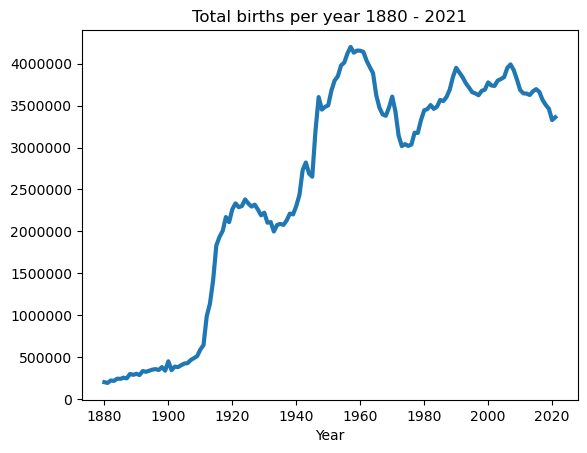

In [808]:
#Lets create a graph to inspect the trend of births each 
#we have 142 years and the amount of births that year


Num_of_Births = df.groupby("Year")["Count"].sum()
#df['Sum of Birth']=df.groupby("Year")["Count"].transform(sum)

#We can see the trend of births were on a steady climb up until 1910, it spiked in births. It again spiked around the time boomers were born in the 50s-60s then dropped in 70 and have been on a steady climb until 2010s.

Num_of_Births.plot(linewidth = 3, title = "Total births per year 1880 - 2021")
plt.ticklabel_format(style="plain", axis ="y")

df

In [810]:
#make dataframe of the total amount of births in a year in USA
Grp_Year = df.groupby('Year').sum()
Grp_Year['Years'] = Grp_Year.index
Grp_Year.reset_index(drop=True, inplace=True)
Grp_Year

,Count,Years
0,201484,1880
1,192699,1881
2,221538,1882
3,216950,1883
4,243467,1884
...,...,...
137,3570234,2017
138,3508655,2018
139,3461444,2019
140,3327419,2020


My prediction using a linear regression is  4645459


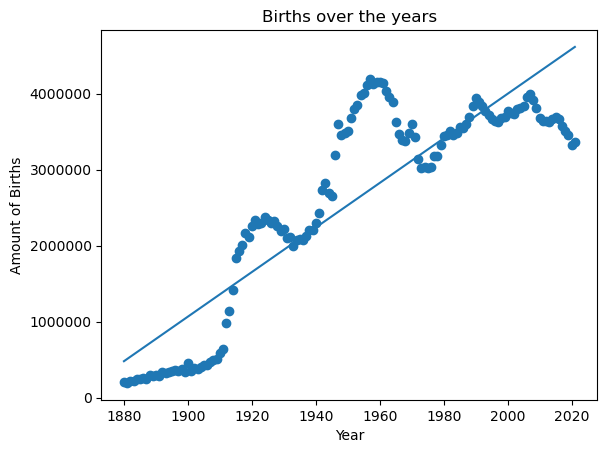

In [811]:
#linear regression model
y = Grp_Year['Count']
x = Grp_Year['Years']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))
Prediction = round(myfunc(2022))

plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel("Year")
plt.ylabel ("Amount of Births")
plt.title('Births over the years')
#plt.show()
print ('My prediction using a linear regression is ', Prediction)



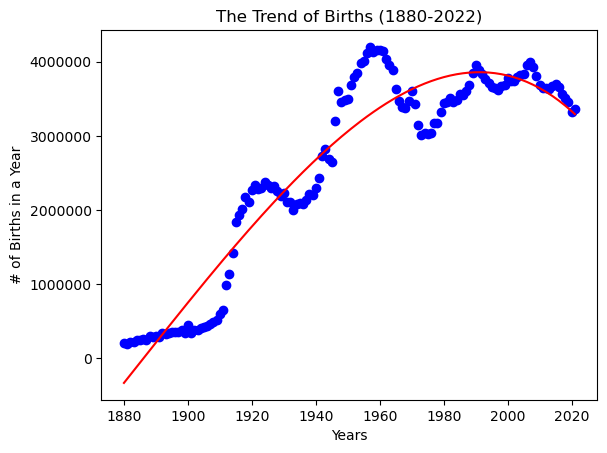

array([2972392.26322083])

In [812]:
#Polynomial regression model

Y = Grp_Year.iloc[:, 0].values
X = Grp_Year.iloc[:, 1:2].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

poly_reg = PolynomialFeatures(degree=8)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, Y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, Y, color='blue')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='red')
    plt.ticklabel_format(useOffset=False, style='plain', axis='Y')
    plt.title('The Trend of Births (1880-2022)')
    plt.xlabel('Years')
    plt.ylabel('# of Births in a Year')
    plt.show()
    return
viz_polymonial()

#Prediction
pol_reg.predict(poly_reg.fit_transform([[2028]]))


,Count
Gender,
F,178951511
M,182773618


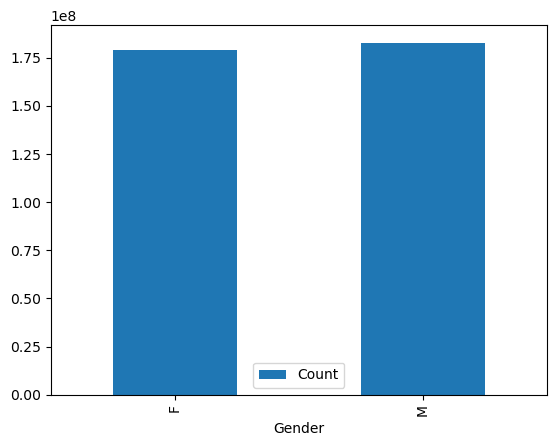

In [816]:
#split the at birth gender for all 142 years
Total_Gender = df.groupby("Gender").sum()
Total_Gender = Total_Gender.drop("Year", axis='columns')


#according to my bar graph we have more Men in the dataframe
Total_Gender.plot.bar()

Total_Gender

Gender,F,M
Year,,
1880,90993,110491
1881,91954,100745
1882,107850,113688
1883,112321,104629
1884,129022,114445
...,...,...
2017,1723043,1847191
2018,1696917,1811738
2019,1673030,1788414


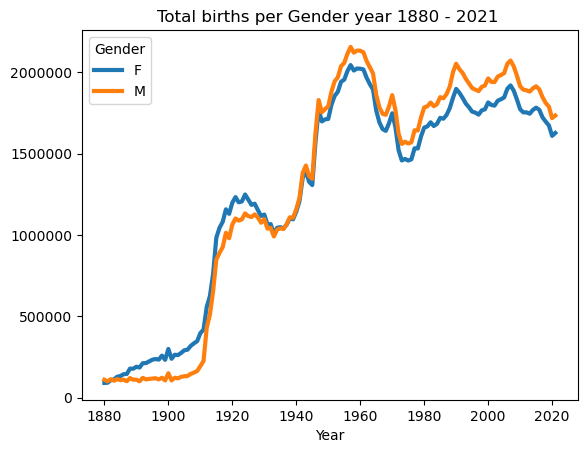

In [817]:
#split the at birth gender of everyone each year
Total_Gender_Birth = df.pivot_table(values="Count", index="Year", columns= "Gender", aggfunc="sum")

#in the early 1900s the USA gave birth to more females than men but by 1950 onward there have been more male births.
Total_Gender_Birth.plot(linewidth = 3, title = "Total births per Gender year 1880 - 2021 ")
plt.ticklabel_format(style="plain", axis ="y")

Total_Gender_Birth

In [818]:
#now that we have a good idea on the dataframe I want to do more research on the name Karen
#I have a hypothesis that the name Karen has dropped in popularity in the 
#recent years 


In [ ]:
#add proportion to dataset
prop_df = df.groupby(["Year","Gender"]).apply(add_prop)
prop_df

In [827]:
#dataframe of karen and the amount of babies born with name Karen

Karen_Year = df[df.eq("Karen").any(1)]
Karen_Year=Karen_Year.groupby('Year').sum()
Karen_Year['Years'] = Karen_Year.index
Karen_Year.reset_index(drop=True, inplace=True)
Karen_Year = Karen_Year.filter(items=["Count", 'Years'])
Karen_Year

,Count,Years
0,6,1881
1,10,1885
2,9,1886
3,9,1887
4,5,1888
...,...,...
131,559,2017
132,469,2018
133,445,2019
134,335,2020


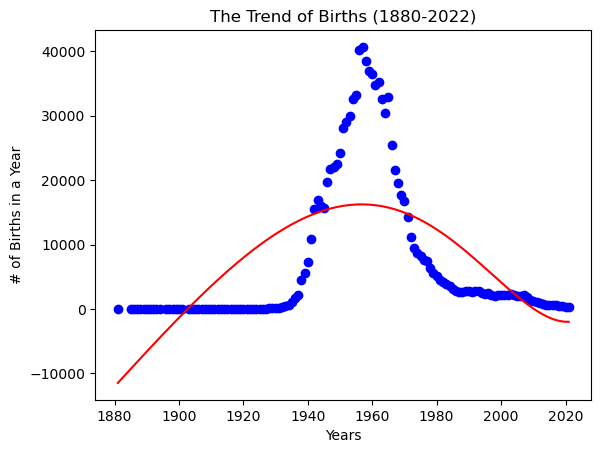

array([-76554.44525926])

In [829]:
#POLY REGRESSION  

Y_Karen = Karen_Year.iloc[:, 0].values
X_Karen = Karen_Year.iloc[:, 1:2].values

X_train, X_test, Y_train, Y_test = train_test_split(X_Karen, Y_Karen, test_size=0.2, random_state=0)

poly_reg_K = PolynomialFeatures(degree=40)
X_poly_K = poly_reg_K.fit_transform(X_Karen)
pol_reg_K = LinearRegression()
pol_reg_K.fit(X_poly_K, Y_Karen)

# Visualizing the Polymonial Regression results
def viz_polymoniall():
    plt.scatter(X_Karen, Y_Karen, color='blue')
    plt.plot(X_Karen, pol_reg_K.predict(poly_reg_K.fit_transform(X_Karen)), color='red')
    plt.ticklabel_format(useOffset=False, style='plain', axis='Y')
    plt.title('The Trend of Births (1880-2022)')
    plt.xlabel('Years')
    plt.ylabel('# of Births in a Year')
    plt.show()
    return
viz_polymoniall()


#Prediction
pol_reg_K.predict(poly_reg_K.fit_transform([[20]]))

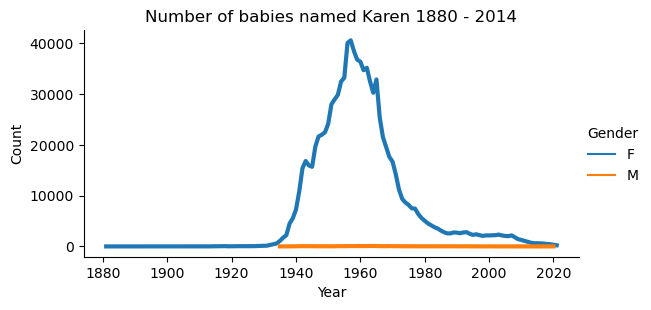

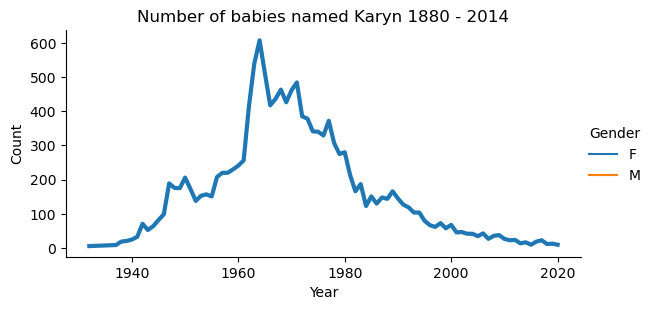

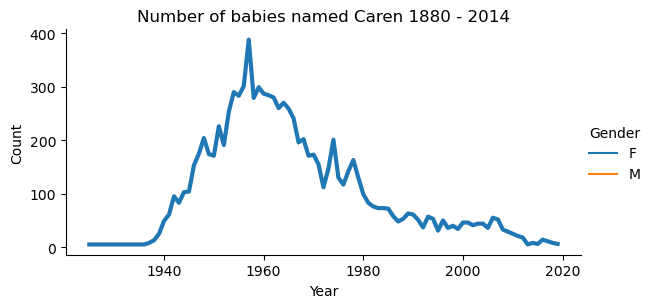

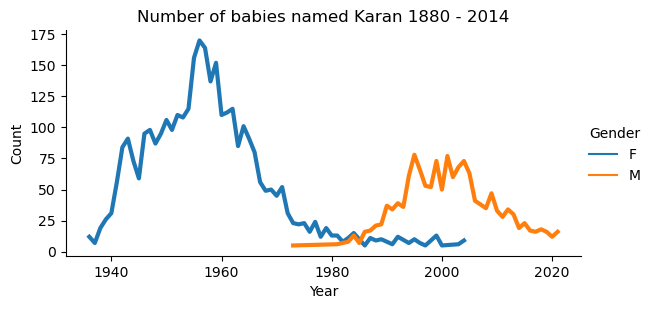

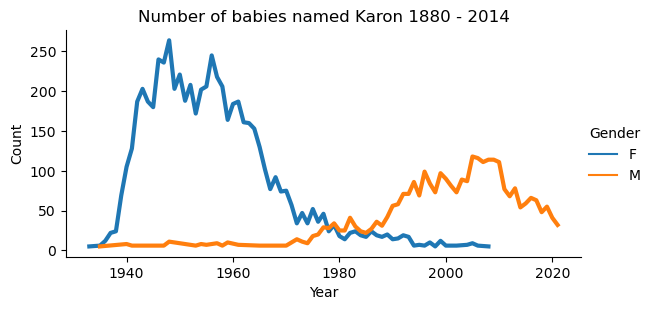

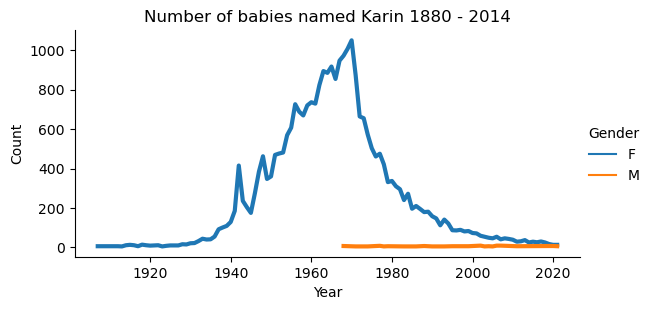

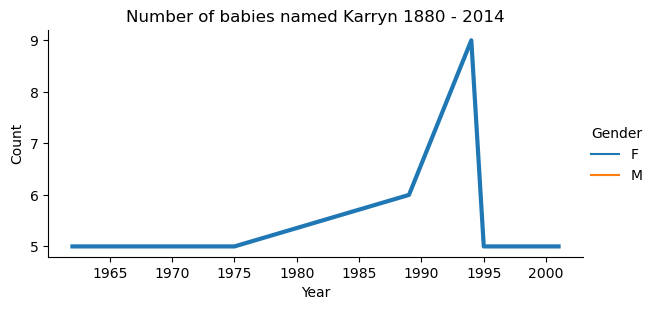

In [830]:
def get_births_many_names(list_of_names):
    for x in range(len(list_of_names)):
        if list_of_names[x] in set(prop_df["Name"]):
            
            name_data  = prop_df[prop_df["Name"] == list_of_names[x]]
            sns.relplot(data= name_data, x = "Year", y = "Count", hue = "Gender", 
                        linewidth = 3, kind = "line", height = 3, aspect = 2, hue_order= ("F","M"))
            plt.title("Number of babies named {} 1880 - 2014".format(list_of_names[x]))
        else:
            print("Name {} not in the database.".format(list_of_names[x]))
            
          #model for names similar to Karen  
            
            
get_births_many_names(["Karen", "Karyn", "Caren", "Karan", "Karon","Karin", "Karryn"])

In [831]:
#get_births_many_names(["Karen", "Karyn", "Caren", "Karan", "Karon","Karin", "Karryn"])

In [832]:

#Not a good strategy because there have been more births as the years have gone
Karen_pop = prop_df[prop_df.eq("Karen").any(1)]

#datafram of karen proportion split into Male and Female
Total_Karen_Birth = Karen_pop.pivot_table(values="Proportion", index="Year", columns= "Gender", aggfunc="sum")
Total_Karen_Birth["M"] = Total_Karen_Birth["M"].replace(np.nan, 0)
Total_Karen_Birth

Gender,F,M
Year,,
1881,0.000065,0.000000
1885,0.000075,0.000000
1886,0.000062,0.000000
1887,0.000062,0.000000
1888,0.000028,0.000000
...,...,...
2017,0.000320,0.000004
2018,0.000276,0.000000
2019,0.000262,0.000003


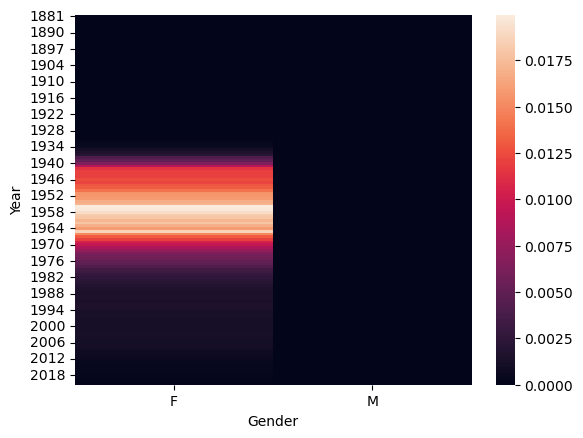

In [835]:

p1 = sns.heatmap(Total_Karen_Birth)